In [ ]:
!git clone https://github.com/grafstor/LogoGen.git
!pip install svgwrite > None
!pip install svg.path > None

Cloning into 'LogoGen'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 88 (delta 34), reused 85 (delta 31), pack-reused 0
Receiving objects: 100% (88/88), 1.10 MiB | 910.00 KiB/s, done.
Resolving deltas: 100% (34/34), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/logo_gen_dataset/data.zip > None

# LogoGan
**Key concept**: Transformer + GAN

In [ ]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker

from IPython.display import SVG, display
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

from transformers import BertTokenizer, BertModel

import LogoGen.converter as converter

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
random_seed = 42
random.seed(random_seed)

torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
class SvgDataset(Dataset):
    def __init__(self, device, seq_len, folders):
        self.device = device

        self.seq_len = seq_len

        self.svg_paths = self.get_svg_paths(folders)

        self.converter = converter.Converter(self.seq_len)

    def get_svg_paths(self, folders):
        svg_paths = []

        for i, folder in enumerate(folders):
            files = [file for file in os.listdir(folder)]

            for file in files:
                svg_name = file[:-4] # del ".svg"
                svg_name = svg_name.split('_')

                if len(svg_name) > 1:
                    svg_name = svg_name[1]
                else:
                    svg_name = svg_name[0]

                svg_name = " ".join([word for word in svg_name.split('-')])

                svg_path = os.path.join(folder, file)

                svg_paths.append([svg_name, svg_path])

        return svg_paths

    def __len__(self):
        return len(self.svg_paths)


    def load_svg(self, path):
        try:
            vector = self.converter.to_vector(self.converter.open(path))
            return vector
        except:
            return None

    def __getitem__(self, idx):

        svg_name, svg_path = self.svg_paths[idx]

        vector = self.load_svg(svg_path)

        if vector and svg_name:
            return (
              torch.tensor(vector).to(self.device),
              svg_name,
            )
        else:
            while True:
                svg_name, svg_path = random.choice(self.svg_paths)
                vector = self.load_svg(svg_path)

                if vector and svg_name:
                    return (
                      torch.tensor(vector).to(self.device),
                      svg_name,
                    )
def to_bert_embedding(sentances):
    encoding = bert_tokenizer.batch_encode_plus(
        sentances,
        padding=True,
        truncation=True,
        return_tensors='pt',
        add_special_tokens=True
    )

    with torch.no_grad():
        outputs = bert_model(encoding['input_ids'], attention_mask=encoding['attention_mask'])
        embedding = outputs.last_hidden_state.mean(dim=1)

    return embedding

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim=768, z_dim=100, seq_len=250, seq_dim=11, num_heads=8, num_layers=6, d_model=512, dim_feedforward=1024, dropout=0.3):
        super(Generator, self).__init__()
        self.seq_len = seq_len
        self.embedding = nn.Linear(input_dim + z_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, seq_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, seq_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, z):
        # src shape: (batch_size, 768)
        # z shape: (batch_size, z_dim)
        combined_input = torch.cat((src, z), dim=1)  # (batch_size, input_dim + z_dim)
        src = self.embedding(combined_input)  # (batch_size, d_model)

        batch_size, d_model = src.size()
        src = src.unsqueeze(1).repeat(1, self.seq_len, 1)  # (batch_size, 250, d_model)

        src = src + self.pos_encoder[:, :self.seq_len, :]

        src = src.permute(1, 0, 2)  # (250, batch_size, d_model)
        output = self.transformer_encoder(src)  # (250, batch_size, d_model)
        output = output.permute(1, 0, 2)  # (batch_size, 250, d_model)

        output = self.dropout(output)
        output = self.fc_out(output)  # (batch_size, 250, seq_dim)
        return output

class Discriminator(nn.Module):
    def __init__(self, seq_len=250, input_dim=11,  num_heads=8, num_layers=6, d_model=512, dim_feedforward=1024, dropout=0.3):
        super(Discriminator, self).__init__()
        self.seq_len = seq_len
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, seq_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, 1)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, src):
        # src shape: (batch_size, 250, input_dim)
        src = self.embedding(src)  # (batch_size, 250, d_model)

        src = src + self.pos_encoder[:, :self.seq_len, :]

        src = src.permute(1, 0, 2)  # (250, batch_size, d_model)
        output = self.transformer_encoder(src)  # (250, batch_size, d_model)
        output = output.permute(1, 0, 2)  # (batch_size, 250, d_model)

        output = self.dropout(output)
        output = self.fc_out(output)  # (batch_size, 250, 1)
        output = torch.mean(output, dim=1)  # (batch_size, 1)
        output = self.sigmoid(output)  # (batch_size, 1)
        return output

In [ ]:
def generate_samples(generator, data_loader, num_samples=3):
    generator.eval()
    c = converter.Converter(seq_len)

    with torch.no_grad():
        for vectors, svg_name in data_loader:
            vectors = vectors[:num_samples]
            svg_name = svg_name[:num_samples]

            conditions = to_bert_embedding(svg_name).to(device)
            z = torch.randn(num_samples, z_dim).to(device).normal_(0.0, 1.0)

            outputs = generator(conditions, z)

            outputs = np.array(outputs.cpu())
            for name, output in zip(svg_name, outputs):
                try:
                    # [print(e) for e in output]
                    print(name)

                    newpath = r'results'
                    if not os.path.exists(newpath):
                        os.makedirs(newpath)

                    svg = c.to_svg(output)
                    svg_path = f'results/test_{time.time()}_{name}.svg'
                    c.save(svg_path, svg)
                    display(SVG(svg_path))

                except Exception as e:
                    print(f"Error generating SVG: {e}")

            break

In [ ]:
seq_len = 25
batch_size = 64

with open('LogoGen/folders.txt', 'r') as f:
    folders = f.read().split('\n')
    folders = [f for f in folders if f]

svg_loader = DataLoader(SvgDataset(device, seq_len, folders), shuffle=True, batch_size=batch_size)

In [ ]:
metrics = {'d_loss': [], 'g_loss': [], 'd_fake_loss': [], 'd_real_loss': []}
num_epochs = 10
learning_rate = 1e-4

z_dim = 128

generator = Generator(seq_len=seq_len, z_dim=z_dim)
discriminator = Discriminator(seq_len=seq_len)

g_parameters = list(generator.parameters())
g_optimizer = optim.Adam(g_parameters, lr=learning_rate)

d_parameters = list(discriminator.parameters())
d_optimizer = optim.Adam(d_parameters, lr=learning_rate)


generator.to(device)
discriminator.to(device)

criterion = nn.MSELoss().to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


fire hydrant


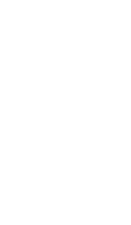

tomatoes tomato


peru


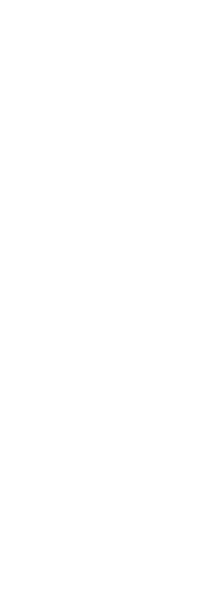

In [ ]:
generate_samples(generator, svg_loader)

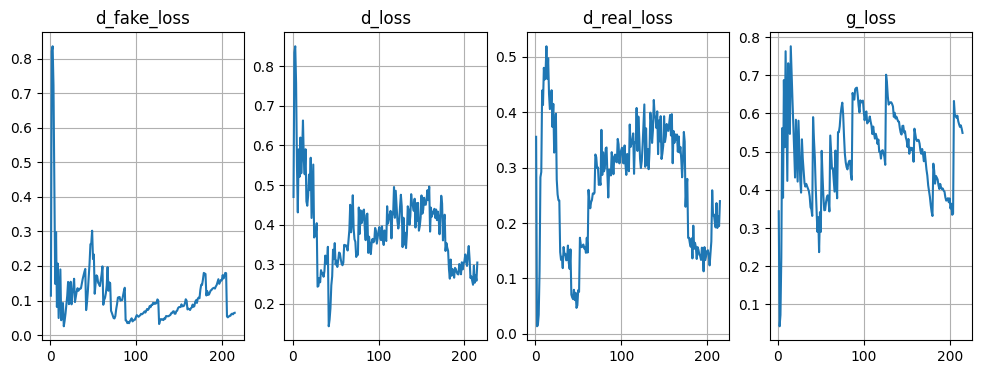

In [ ]:
for vectors, svg_name in tqdm(svg_loader):
    generator.train()
    discriminator.train()

    conditions = to_bert_embedding(svg_name).to(device)
    z = torch.randn(batch_size, z_dim).to(device)


    g_outputs = generator(conditions, z)



    real_output = discriminator(vectors)
    fake_output = discriminator(g_outputs.detach())

    fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
    real_loss = criterion(real_output, torch.ones_like(real_output))

    d_loss = fake_loss + real_loss

    step = len(metrics['d_loss']) + 1
    metrics['d_loss'].append((step, d_loss.item()))
    metrics['d_fake_loss'].append((step, fake_loss.item()))
    metrics['d_real_loss'].append((step, real_loss.item()))

    if not metrics['g_loss'] or metrics['g_loss'][-1][1] < d_loss.item():
        d_optimizer.zero_grad()
        d_loss.backward()
        nn.utils.clip_grad_norm_(d_parameters, max_norm=0.5)
        d_optimizer.step()



    fake_output = discriminator(g_outputs)

    g_loss = criterion(fake_output, torch.ones_like(fake_output))

    metrics['g_loss'].append((step, g_loss.item()))

    g_optimizer.zero_grad()
    g_loss.backward()
    nn.utils.clip_grad_norm_(g_parameters, max_norm=0.5)
    g_optimizer.step()

    if step % 5 == 0:
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()

    if step % 10 == 0:
        generate_samples(generator, svg_loader)

    print(f"Epoch {step+1}, DLoss: {d_loss.item()}, GLoss: {g_loss.item()}")